In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

In [4]:
df = pd.read_csv('/content/gurgaon_properties_post_feature_selection_v2.csv')

In [5]:
df.head()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 36,0.82,3.0,2.0,2,New Property,850.0,0.0,0.0,0.0,Low,Low Floor
1,flat,sector 89,0.95,2.0,2.0,2,New Property,1226.0,1.0,0.0,0.0,Low,Mid Floor
2,flat,sohna road,0.32,2.0,2.0,1,New Property,1000.0,0.0,0.0,0.0,Low,High Floor
3,flat,sector 92,1.60,3.0,4.0,3+,Relatively New,1615.0,1.0,0.0,1.0,High,Mid Floor
4,flat,sector 102,0.48,2.0,2.0,1,Relatively New,582.0,0.0,1.0,0.0,High,Mid Floor


In [6]:
df['furnishing_type'].value_counts()

,count
furnishing_type,
0.0,2349
1.0,1018
2.0,187


In [10]:
# 0 -> unfurnished
# 1 -> semifurnished
# 2 -> furnished
df['furnishing_type'] = df['furnishing_type'].replace({0.0:'unfurnished',1.0:'semifurnished',2.0:'furnished'})

In [11]:
df['balcony'] = df['balcony'].replace({"0":"Zero","1":"One","2":"Two","3":"Three","3+":"Three plus"})

In [12]:
df.head()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 36,0.82,3.0,2.0,Two,New Property,850.0,0.0,0.0,unfurnished,Low,Low Floor
1,flat,sector 89,0.95,2.0,2.0,Two,New Property,1226.0,1.0,0.0,unfurnished,Low,Mid Floor
2,flat,sohna road,0.32,2.0,2.0,One,New Property,1000.0,0.0,0.0,unfurnished,Low,High Floor
3,flat,sector 92,1.60,3.0,4.0,Three plus,Relatively New,1615.0,1.0,0.0,semifurnished,High,Mid Floor
4,flat,sector 102,0.48,2.0,2.0,One,Relatively New,582.0,0.0,1.0,unfurnished,High,Mid Floor


In [13]:
import seaborn as sns

In [14]:
X = df.drop(columns=['price'])
y = df['price']

In [15]:
# Applying the log1p transformation to the target variable
y_transformed = np.log1p(y)

<Axes: xlabel='price', ylabel='Density'>

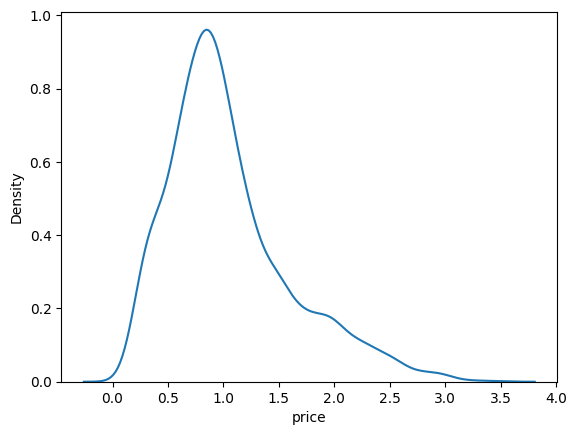

In [ ]:
sns.kdeplot(x=y_transformed)

### Ordinal Encoding

In [ ]:
columns_to_encode = ['property_type','sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']

In [ ]:
# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode)
    ],
    remainder='passthrough'
)

In [ ]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

In [ ]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['property_type', 'sector',
                                                   'balcony', 'agePossession',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category'])])),
                ('regressor', LinearRegression())])

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
y_pred = np.expm1(y_pred)

In [ ]:
mean_absolute_error(np.expm1(y_test),y_pred)

0.9520878996642704

In [ ]:
r2_score(np.expm1(y_test),y_pred)

0.34334590323444825

In [ ]:
def scorer(model_name, model):

    output = []

    output.append(model_name)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

    output.append(scores.mean())

    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

    pipeline.fit(X_train,y_train)

    y_pred = pipeline.predict(X_test)

    y_pred = np.expm1(y_pred)

    output.append(mean_absolute_error(np.expm1(y_test),y_pred))

    return output


In [ ]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [ ]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [ ]:
model_output

[['linear_reg', 0.7333868067156334, 0.9520878996642704],
 ['svr', 0.7637671649443487, 0.8514748152062912],
 ['ridge', 0.7333901563012646, 0.9520245948216415],
 ['LASSO', 0.05943378064493573, 1.528905986892753],
 ['decision tree', 0.7669606726323716, 0.7316319057794225],
 ['random forest', 0.8814120345433262, 0.5313898981011203],
 ['extra trees', 0.8701406902284166, 0.5427138034754773],
 ['gradient boosting', 0.871380032869902, 0.5779454315264516],
 ['adaboost', 0.7545947063297602, 0.8425989505125834],
 ['mlp', 0.8097230595825596, 0.787482648193046],
 ['xgboost', 0.8930239189767697, 0.5081856139341655]]

In [ ]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [ ]:
model_df.sort_values(['mae'])

,name,r2,mae
10,xgboost,0.893024,0.508186
5,random forest,0.881412,0.531390
6,extra trees,0.870141,0.542714
7,gradient boosting,0.871380,0.577945
4,decision tree,0.766961,0.731632
9,mlp,0.809723,0.787483
8,adaboost,0.754595,0.842599
1,svr,0.763767,0.851475
2,ridge,0.733390,0.952025
0,linear_reg,0.733387,0.952088


### OneHotEncoding

In [ ]:
# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first'),['sector','agePossession','furnishing_type'])
    ],
    remainder='passthrough'
)

In [ ]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

In [ ]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['property_type', 'sector',
                                                   'balcony', 'agePossession',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category']),
                                                 ('cat1',
                                                  OneHotEncoder(drop='first'),
                                                  ['sector', 'agePossession',
                                                   'furnishing_type'])])),
                ('regressor', LinearRegression())])

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
y_pred = np.expm1(y_pred)

In [ ]:
mean_absolute_error(np.expm1(y_test),y_pred)

0.6561118465728528

In [ ]:
def scorer(model_name, model):

    output = []

    output.append(model_name)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

    output.append(scores.mean())

    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

    pipeline.fit(X_train,y_train)

    y_pred = pipeline.predict(X_test)

    y_pred = np.expm1(y_pred)

    output.append(mean_absolute_error(np.expm1(y_test),y_pred))

    return output


In [ ]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [ ]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [ ]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [ ]:
model_df.sort_values(['mae'])

,name,r2,mae
6,extra trees,0.897034,0.471262
5,random forest,0.889516,0.504842
10,xgboost,0.894958,0.505213
9,mlp,0.871962,0.536434
7,gradient boosting,0.873349,0.568216
0,linear_reg,0.852942,0.656112
2,ridge,0.853058,0.660395
4,decision tree,0.797573,0.707036
8,adaboost,0.757899,0.807858
1,svr,0.769756,0.836153


### OneHotEncoding With PCA

In [ ]:
# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),['sector','agePossession'])
    ],
    remainder='passthrough'
)

In [ ]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95)),
    ('regressor', LinearRegression())
])

In [ ]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [ ]:
scores.mean()

0.06225201431451135

In [ ]:
scores.std()

0.01986059407164014

In [ ]:
def scorer(model_name, model):

    output = []

    output.append(model_name)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=0.95)),
        ('regressor', model)
    ])

    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

    output.append(scores.mean())

    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

    pipeline.fit(X_train,y_train)

    y_pred = pipeline.predict(X_test)

    y_pred = np.expm1(y_pred)

    output.append(mean_absolute_error(np.expm1(y_test),y_pred))

    return output


In [ ]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [ ]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [ ]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [ ]:
model_df.sort_values(['mae'])

,name,r2,mae
5,random forest,0.762912,0.653758
10,xgboost,0.769887,0.679862
6,extra trees,0.739560,0.700014
4,decision tree,0.696182,0.757290
7,gradient boosting,0.610604,0.987906
8,adaboost,0.315161,1.340912
1,svr,0.218073,1.361163
9,mlp,0.214025,1.417001
2,ridge,0.062252,1.526707
0,linear_reg,0.062252,1.526707


In [17]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.4 MB/s eta 0:00:00


In [18]:
import category_encoders as ce

### Hyperparameter Tuning

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
param_grid = {
    'regressor__n_estimators': [50, 100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__max_samples':[0.1, 0.25, 0.5, 1.0],
    'regressor__max_features': ['auto', 'sqrt']
}

In [21]:
columns_to_encode = ['property_type','sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']

# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),['agePossession']),
        ('target_enc', ce.TargetEncoder(), ['sector'])
    ],
    remainder='passthrough'
)

In [22]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

In [23]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [24]:
search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='r2', n_jobs=-1, verbose=4)

In [25]:
search.fit(X, y_transformed)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
640 fits failed out of a total of 1280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
321 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, 

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['bedRoom',
                                                                          'bathroom',
                                                                          'built_up_area',
                                                                          'servant '
                                                                          'room',
                                                                          'store '
                                                                          'room']),
                                                                        ('cat',
                                                                         OrdinalEncoder(),
                                                                         ['property_type',
                                                                          'sector',
                                                                          'balcony',
                                                                          'agePossession',
                                                                          'furnishing_type',...
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['agePossession']),
                                                                        ('target_enc',
                                                                         TargetEncoder(),
                                                                         ['sector'])])),
                                       ('regressor', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None, 10, 20, 30],
                         'regressor__max_features': ['auto', 'sqrt'],
                         'regressor__max_samples': [0.1, 0.25, 0.5, 1.0],
                         'regressor__n_estimators': [50, 100, 200, 300]},
             scoring='r2', verbose=4)

In [26]:
final_pipe = search.best_estimator_

In [27]:
search.best_params_

{'regressor__max_depth': None,
 'regressor__max_features': 'sqrt',
 'regressor__max_samples': 1.0,
 'regressor__n_estimators': 200}

In [28]:
search.best_score_

np.float64(0.9027804189088426)

In [29]:
final_pipe.fit(X,y_transformed)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['property_type', 'sector',
                                                   'balcony', 'agePossession',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category']),
                                                 ('cat1',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['agePossession']),
                                                 ('target_enc', TargetEncoder(),
                                                  ['sector'])])),
                ('regressor',
                 RandomForestRegressor(max_features='sqrt', max_samples=1.0,
                                       n_estimators=200))])

### Exporting the model

In [30]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),['sector','agePossession'])
    ],
    remainder='passthrough'
)

In [31]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=500))
])

In [32]:
pipeline.fit(X,y_transformed)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['property_type', 'sector',
                                                   'balcony', 'agePossession',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category']),
                                                 ('cat1',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['sector',
                                                   'agePossession'])])),
                ('regressor', RandomForestRegressor(n_estimators=500))])

In [33]:
import pickle

with open('pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

In [34]:
with open('df.pkl', 'wb') as file:
    pickle.dump(X, file)

In [35]:
X

,property_type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 36,3.0,2.0,Two,New Property,850.0,0.0,0.0,unfurnished,Low,Low Floor
1,flat,sector 89,2.0,2.0,Two,New Property,1226.0,1.0,0.0,unfurnished,Low,Mid Floor
2,flat,sohna road,2.0,2.0,One,New Property,1000.0,0.0,0.0,unfurnished,Low,High Floor
3,flat,sector 92,3.0,4.0,Three plus,Relatively New,1615.0,1.0,0.0,semifurnished,High,Mid Floor
4,flat,sector 102,2.0,2.0,One,Relatively New,582.0,0.0,1.0,unfurnished,High,Mid Floor
...,...,...,...,...,...,...,...,...,...,...,...,...
3549,flat,sector 84,2.0,2.0,One,Relatively New,532.0,0.0,0.0,unfurnished,Medium,Mid Floor
3550,house,sector 109,5.0,5.0,Three plus,Relatively New,6228.0,1.0,1.0,unfurnished,High,Low Floor
3551,flat,sector 2,1.0,1.0,One,Moderately Old,665.0,0.0,0.0,semifurnished,Medium,Mid Floor
3552,house,sector 43,5.0,6.0,Three,Moderately Old,5490.0,1.0,1.0,unfurnished,Medium,Mid Floor


### Trying out the predictions

In [36]:
X.columns

Index(['property_type', 'sector', 'bedRoom', 'bathroom', 'balcony',
       'agePossession', 'built_up_area', 'servant room', 'store room',
       'furnishing_type', 'luxury_category', 'floor_category'],
      dtype='object')

In [37]:
X.iloc[0].values

array(['flat', 'sector 36', np.float64(3.0), np.float64(2.0), 'Two',
       'New Property', np.float64(850.0), np.float64(0.0),
       np.float64(0.0), 'unfurnished', 'Low', 'Low Floor'], dtype=object)

In [41]:
data = [['house', 'sector 102', 4, 3, 'Three plus', 'New Property', 2750, 0, 0, 'unfurnished', 'Low', 'Low Floor']]
columns = ['property_type', 'sector', 'bedRoom', 'bathroom', 'balcony',
       'agePossession', 'built_up_area', 'servant room', 'store room',
       'furnishing_type', 'luxury_category', 'floor_category']

# Convert to DataFrame
one_df = pd.DataFrame(data, columns=columns)

one_df


,property_type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,house,sector 102,4,3,Three plus,New Property,2750,0,0,unfurnished,Low,Low Floor


In [42]:
np.expm1(pipeline.predict(one_df))

array([3.25433203])

In [40]:
X.dtypes

,0
property_type,object
sector,object
bedRoom,float64
bathroom,float64
balcony,object
agePossession,object
built_up_area,float64
servant room,float64
store room,float64
furnishing_type,object


In [43]:
sorted(X['sector'].unique().tolist())

['dwarka expressway',
 'gwal pahari',
 'manesar',
 'sector 1',
 'sector 10',
 'sector 102',
 'sector 103',
 'sector 104',
 'sector 105',
 'sector 106',
 'sector 107',
 'sector 108',
 'sector 109',
 'sector 11',
 'sector 110',
 'sector 111',
 'sector 112',
 'sector 113',
 'sector 12',
 'sector 13',
 'sector 14',
 'sector 15',
 'sector 17',
 'sector 2',
 'sector 21',
 'sector 22',
 'sector 23',
 'sector 24',
 'sector 25',
 'sector 26',
 'sector 27',
 'sector 28',
 'sector 3',
 'sector 30',
 'sector 31',
 'sector 33',
 'sector 36',
 'sector 37',
 'sector 37d',
 'sector 38',
 'sector 39',
 'sector 4',
 'sector 40',
 'sector 41',
 'sector 43',
 'sector 45',
 'sector 46',
 'sector 47',
 'sector 48',
 'sector 49',
 'sector 5',
 'sector 50',
 'sector 51',
 'sector 52',
 'sector 53',
 'sector 54',
 'sector 55',
 'sector 56',
 'sector 57',
 'sector 58',
 'sector 59',
 'sector 6',
 'sector 60',
 'sector 61',
 'sector 62',
 'sector 63',
 'sector 63a',
 'sector 65',
 'sector 66',
 'sector 67',
 'se